In [ ]:
import numpy as np
import torch
import logging
import matplotlib.pyplot as plt

ftype = torch.float32
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [21]:
s_box = [
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
]
hamming_weight = torch.tensor([np.bitwise_count(i) for i in range(256)], dtype=ftype)

In [22]:
reverse_s_box = [0 for _ in range(len(s_box))]
for i in range(len(s_box)):
    reverse_s_box[s_box[i]] = i

reverse_s_box_tensor = torch.tensor(s_box, dtype=torch.int32)

AES_HD Dataset from:
https://github.com/AESHD/AES_HD_Dataset

Contains traces from unprotected run. Does not contain ciphertexts. 100,000 traces with 1250 features.

A copy of this AES_HD was found in 
https://github.com/gabzai/Methodology-for-efficient-CNN-architectures-in-SCA

This copy does contain relevant ciphertexts. Contains only 75,000 traces. First we'll test whether the labels and traces are identical

In [ ]:
# load data from alternative source
traces_npy = np.concatenate([
    np.load("AES_HD_dataset/profiling_traces_AES_HD.npy"),
    np.load("AES_HD_dataset/attack_traces_AES_HD.npy")
])

labels_npy = np.concatenate([
    np.load("AES_HD_dataset/profiling_labels_AES_HD.npy"),
    np.load("AES_HD_dataset/attack_labels_AES_HD.npy")
]).flatten()

traces shape equality test True
label shape equality test True


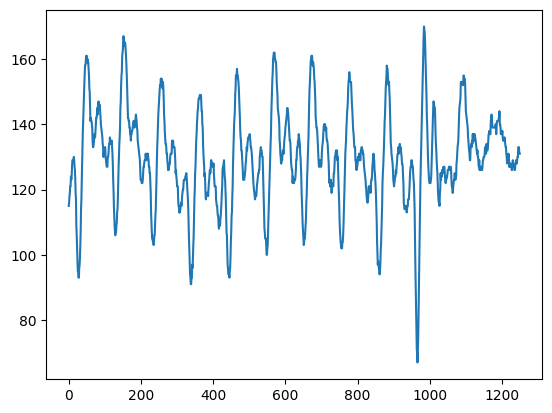

In [ ]:
plt.plot(traces_npy[0])

In [27]:
reference_ciphertext = np.concat([
    np.load("AES_HD_dataset/profiling_ciphertext_AES_HD.npy"),
    np.load("AES_HD_dataset/attack_ciphertext_AES_HD.npy")
]).astype(np.int32)
reference_ciphertext = torch.tensor(reference_ciphertext)

First we will separate traces based on the correct key. We will use key with most corresponding traces to perform CPA.

In [28]:
labels = torch.tensor(labels_npy, dtype=torch.int32)

source_ciphertext = reference_ciphertext[:, 11]
reference_ciphertext = reference_ciphertext[:, 7]

max_traces_key = -1
max_indices = torch.tensor([])
for key_hypothesis in range(256):
    # simulate model
    xor = key_hypothesis ^ source_ciphertext
    switch = reverse_s_box_tensor[xor]
    switch_xor = switch ^ reference_ciphertext

    # get indices where model is equal to labels
    indices = ((labels == switch_xor).nonzero().flatten())
    if indices.shape[0] > max_indices.shape[0]:
        max_traces_key = key_hypothesis
        max_indices = indices

In [29]:
max_traces_key, max_indices.shape

(134, torch.Size([2048]))

We will be performing CPA on the largest set of traces with a fixed key. This turns out to be key 215, with 337 traces.

In [30]:
def correlate_traces(source_ciphertext: torch.tensor,
                     reference_ciphertext: torch.tensor,
                     traces_centered: torch.tensor,
                     traces_squared_centered_sum: torch.tensor):
    """
    Computes Pearson's R correlation between hamming weights of sbox output for
    each key hypothesis, and traces for each of 256 key hypotheses.

    Correlation is computed as Pearson's r, based on formula:
    correlation = Cov(iv, trace)
                  / ( std(iv) * std(trace))

    Using vectorized computation, this is performed as
    correlation = dot_product((iv - mean(iv), (trace - mean(trace))
                  / sqrt( (iv - mean(iv))^2 * (trace - mean(trace)^2)

    Performance increase is gained by using precomputed traces_centered as well
    as traces_std. 

    Assumes
    - i = amount of traces
    - j = amount of samples per trace
    :source_ciphertext: tensor containing held value if ciphertext,
                        shaped (i, 1)
    :reference_ciphertext: tensor containing previous value of ciphertext,
                           shaped (i, 1)
    :traces_centered: precomputed traces - traces.mean(axis=0), shaped (i, j)
    :traces_std: precomputed traces.std(axis=0) shaped (j,)

    :returns: array of correlations shaped (256, j)
    """
    I = reference_ciphertext.shape[0]
    iv = torch.zeros((256, I), dtype=ftype)
    for key_hypothesis in range(256):
        # Sbox(key_hypothesis ^ plaintext)
        xor = key_hypothesis ^ source_ciphertext
        switch = reverse_s_box_tensor[xor]

        # hamming distance of sbox output and reference ciphertext
        weights = hamming_weight[switch ^ reference_ciphertext]
        iv[key_hypothesis] = weights

    iv_centered = iv - iv.mean(dim=1, keepdim=True)
    iv_centered_squared_sum = torch.sum(iv_centered**2, dim=1, keepdim=True)

    # (iv - iv.mean()) * (traces - traces.mean(dim=0))
    # matrix multiplication between iv_{256, I} and traces_{I, J}
    nom = torch.matmul(iv_centered, traces_centered) 
    # sqrt(sum(iv - iv.mean())**2 * sum(traces - traces.mean(dim=0))**2)
    # inner multiplication is between iv_{256, 1} and traces_{1, J}
    denom = torch.sqrt(iv_centered_squared_sum * traces_squared_centered_sum)
    return nom / denom


In [31]:
# prepare traces
traces = torch.tensor(traces_npy[max_indices], dtype=ftype)
traces_centered = traces - traces.mean(dim=0)
traces_squared_centered_sum = torch.sum(traces_centered**2, dim=0, keepdim=True)
traces.dtype

torch.float32

In [32]:
ciphertext = np.concat([
    np.load("AES_HD_dataset/profiling_ciphertext_AES_HD.npy"),
    np.load("AES_HD_dataset/attack_ciphertext_AES_HD.npy")
]).astype(np.int32)[max_indices]
ciphertext = torch.tensor(ciphertext)

In [33]:
corrs = correlate_traces(ciphertext[:, 11],
                         ciphertext[:, 7],
                         traces_centered,
                         traces_squared_centered_sum)

In [34]:
abscorr = corrs.abs()
# maximum correlation of each key hypotesis, with sample index
hypo_max_correlation, hypo_sample_index = abscorr.max(dim=1)
byte_max_correlation, byte_guess = hypo_max_correlation.max(dim=0)

In [35]:
byte_max_correlation

tensor(0.1142)

In [36]:
correct_key = max_traces_key
hypo = byte_guess.item()
print(f"hypothesis {hypo:3} reached at {hypo_sample_index[hypo]}")
print(f"has correlation {byte_max_correlation.item():.3f}", end='')
if correct_key == hypo:
    print(" is correct")
else:
    print(f"\nkey is {correct_key:3} with {hypo_max_correlation[correct_key]:.5f}")
            

hypothesis 134 reached at 965
has correlation 0.114 is correct


Our attack succesfully the key.

In [37]:
def graph_correlation():
    correct_key_byte = max_traces_key
    array = corrs
    for i in range(256):
        if i == correct_key_byte:
            color = "green"
        else:
            color = "gray"
        plt.plot(array[i], color=color)
    plt.plot(array[correct_key_byte])
    plt.show()

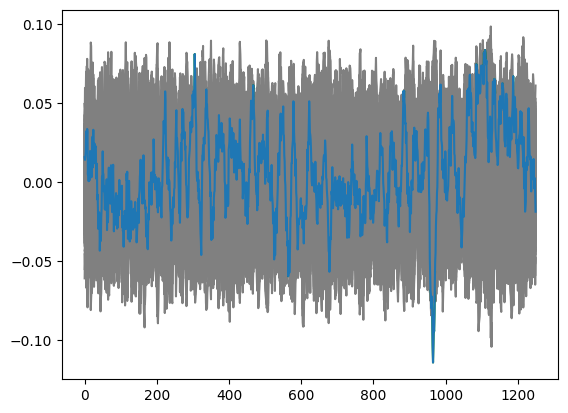

In [38]:
graph_correlation()